# Notebook 03 — Global (Single-Regime) Baseline Modeling

In this step, we train **one model over the entire sample** (ignoring regimes) to establish a clean baseline.  
The goal is to quantify the value of per-regime modeling later by comparing against a strong global benchmark.

**Main steps:**
1. Load engineered features (from Notebook 02) and aligned prices if needed.
2. Build next-day direction target (`y_next`) from shifted returns.
3. Define candidate models:
   - Logistic Regression (`class_weight='balanced'`)
   - XGBoost (tabular-friendly defaults with sensible regularization)
4. Perform **rolling time-series cross-validation** (with purge/embargo if configured).
5. Evaluate & select:
   - Primary metric: F1 (macro/positive class). Tiebreaker: AUC; also track logloss and calibration.
6. Fit the chosen global model on the full training window; produce OOF predictions and feature importance (where applicable).
7. Save:
   - Trained baseline model(s)
   - OOF predictions & CV metrics
   - Artifacts for downstream backtesting (pred-proba, thresholds, feature list)


## Colab setup + project paths

In [8]:

import os, sys, json
from pathlib import Path

# Detect Colab
IN_COLAB = False
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

# Mount Drive & set PROJECT_ROOT
if IN_COLAB:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')
    PROJECT_ROOT = Path("/content/drive/MyDrive/FINAL_PROJECT_MLDL")
else:
    PROJECT_ROOT = Path(".").resolve()

PROJECT_ROOT.mkdir(parents=True, exist_ok=True)
print("PROJECT_ROOT:", PROJECT_ROOT)

%cd "$PROJECT_ROOT"

# Ensure src is importable
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))
print("SRC_DIR on sys.path:", str(SRC_DIR) in sys.path or str(SRC_DIR) == sys.path[0])

# Folders
CFG_DIR  = PROJECT_ROOT / "config"
DATA_DIR = PROJECT_ROOT / "data"
PROC_DIR = DATA_DIR / "processed"
PROC_DIR.mkdir(parents=True, exist_ok=True)
print("PROC_DIR:", PROC_DIR)

# Select Asset
ASSET_KEY = "eurusd"

# Colab deps (idempotent)
if IN_COLAB:
    try:
        import pyarrow, sklearn, yaml  # noqa: F401
    except Exception:
        !pip -q install pyarrow scikit-learn pyyaml


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PROJECT_ROOT: /content/drive/MyDrive/FINAL_PROJECT_MLDL
/content/drive/MyDrive/FINAL_PROJECT_MLDL
SRC_DIR on sys.path: True
PROC_DIR: /content/drive/MyDrive/FINAL_PROJECT_MLDL/data/processed


## Load features and build target

1. **Config & File Access**  
   - Load `base.yaml` settings.  
   - Define helper `asset_file()` for processed data paths.

2. **Load Processed Data**  
   - `aligned` → price data.  
   - `features` → engineered features.

3. **Target Creation**  
   - Compute 1-day returns (`ret1`).  
   - Create binary target `y_next` (1 = up, 0 = down).

4. **Merge & Prepare**  
   - Align target with features on `Date`.  
   - Drop missing targets, ensure numeric `X`.  

5. **Final Output**  
   - `X`: numeric features.  
   - `y`: next-day direction labels.  


In [9]:

import pandas as pd
import numpy as np
import yaml

cfg_path = CFG_DIR / "base.yaml"
assert cfg_path.exists(), f"Missing config at {cfg_path}"
base = yaml.safe_load(open(cfg_path))

def asset_file(stem: str) -> Path:
    return PROC_DIR / f"{ASSET_KEY}_{stem}.parquet"

# Load processed data from notebooks 01 & 02
aligned = pd.read_parquet(asset_file("aligned"))      # prices
features = pd.read_parquet(asset_file("features"))    # engineered features

# Build next-day direction target
tgt_close_cols = [c for c in aligned.columns if isinstance(c,str) and c.startswith("target_") and c.endswith("_Close")]
if not tgt_close_cols:
    tgt_close_cols = [c for c in aligned.columns if c == "target_Close"]
assert tgt_close_cols, "target close not found"
tgt_col = tgt_close_cols[0]

aligned = aligned.sort_values("Date").reset_index(drop=True)
aligned["ret1"]   = aligned[tgt_col].pct_change()
aligned["y_next"] = np.sign(aligned["ret1"].shift(-1)).replace({-1:0, 1:1}).astype("Int64")

# Merge target into features
if "Date" not in features.columns:
    features = features.reset_index().rename(columns={"index":"Date"})
features["Date"] = pd.to_datetime(features["Date"])

df = (features
      .merge(aligned[["Date","y_next"]], on="Date", how="inner")
      .dropna(subset=["y_next"])
      .sort_values("Date")
      .reset_index(drop=True))

# X / y
y = df["y_next"].astype(int).values
X = df.drop(columns=["y_next","Date"]).select_dtypes(include=[np.number])
feat_cols = X.columns.tolist()

print("Data:", df.shape, "| Num features:", len(feat_cols))
df.head(3)


Data: (3851, 140) | Num features: 138


,bench_ret1,bench_ret5,bench_vol5,bench_ma5,bench_ret10,bench_vol10,bench_ma10,bench_ret20,bench_vol20,bench_ma20,...,corr_gold_20,corr_gold_60,corr_tnx_20,corr_tnx_60,corr_vix_20,corr_vix_60,corr_wti_20,corr_wti_60,Date,y_next
0,0.006347,0.006262,0.082637,-0.003069,0.020029,0.080168,-0.005735,0.052848,0.072610,-0.018377,...,0.451669,0.529561,-0.435122,-0.058821,-0.419254,-0.255901,0.578812,0.510533,2010-03-29,0
1,0.000682,-0.000085,0.065128,-0.003765,0.012658,0.072999,-0.005162,0.050655,0.072918,-0.016635,...,0.428133,0.532730,-0.426478,-0.075413,-0.388838,-0.257035,0.557085,0.510739,2010-03-30,1
2,-0.003407,0.001369,0.058853,-0.000085,0.003260,0.071338,-0.001436,0.046142,0.075707,-0.011067,...,0.442748,0.534234,-0.474911,-0.101520,-0.310638,-0.243188,0.562589,0.515981,2010-03-31,1


## Rolling Cross‑Validation

In [10]:

from sklearn.model_selection import TimeSeriesSplit
N_SPLITS = 5
tscv = TimeSeriesSplit(n_splits=N_SPLITS)


## Baseline models (LogReg, XGBoost)

### Model Definitions
This block defines the baseline models in a dictionary called MODELS.
Each entry uses a sklearn.pipeline.Pipeline to chain preprocessing and modeling steps.

1. **Logistic Regression** ("logreg")
- Scaler: StandardScaler (zero mean, unit variance) — improves convergence for gradient-based methods.
- Classifier: LogisticRegression with:
- max_iter=300 → allows more iterations for convergence.
- class_weight="balanced" → adjusts weights inversely to class frequencies to handle imbalance.

2. **XGBoost Classifier** ("xgb")
- Scaler: StandardScaler — while tree-based models don’t require scaling, it improves numeric stability in mixed workflows.
- Classifier: xgb.XGBClassifier tuned for structured financial data:
    - n_estimators=700 → number of boosting rounds.
    - max_depth=4 → shallow trees to reduce overfitting.
    - learning_rate=0.03 → small step size for gradual learning.
    - subsample=0.9, colsample_bytree=0.9 → stochasticity for better generalization.
    - reg_lambda=1.0 → L2 regularization.
    - tree_method="hist" → faster histogram-based training.
    - eval_metric="logloss" → appropriate for probabilistic classification.

In [11]:

!pip -q install xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 MB 3.3 MB/s eta 0:00:00


In [12]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

MODELS = {
    "logreg": Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("clf", LogisticRegression(max_iter=300, class_weight="balanced"))
    ]),
    "xgb": Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),  # helps numeric stability
        ("clf", xgb.XGBClassifier(
            n_estimators=700, max_depth=4, learning_rate=0.03,
            subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
            random_state=42, tree_method="hist", n_jobs=-1,
            eval_metric="logloss"
        ))
    ])
}
list(MODELS.keys())


['logreg', 'xgb']

## Rolling‑CV training & out‑of‑fold metrics

We evaluate each model (`logreg`, `xgb`) using **time-series cross-validation** with OOF predictions.

### Steps
1. **Metric Function (`eval_class`)**  
   - Threshold probs at 0.5 → predictions.  
   - Compute: Accuracy, Precision, Recall, F1, ROC-AUC (if both classes present).

2. **CV Loop**  
   - For each fold: fit model → predict probabilities → store in `oof`.  
   - After CV: compute metrics on all OOF predictions.  
   - Save metrics in `results`, OOF preds in `oof_holder`.

3. **Output**  
   - Print metrics per model.
   - Summary DataFrame for comparison.

**Notes:**  
- Rolling CV preserves time order → avoids leakage.  
- OOF metrics provide realistic, unbiased performance estimates.

In [13]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

def eval_class(y_true, prob):
    pred = (prob >= 0.5).astype(int)
    out = {
        "acc": accuracy_score(y_true, pred),
        "prec": precision_score(y_true, pred, zero_division=0),
        "rec": recall_score(y_true, pred, zero_division=0),
        "f1": f1_score(y_true, pred, zero_division=0),
    }
    # AUC only defined if both classes present
    out["auc"] = roc_auc_score(y_true, prob) if len(np.unique(y_true)) > 1 else np.nan
    return out

results = {}
oof_holder = {}

for name, pipe in MODELS.items():
    oof = np.full(len(df), np.nan, dtype=float)
    for tr_idx, va_idx in tscv.split(X):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]
        pipe.fit(X_tr, y_tr)
        p = pipe.predict_proba(X_va)[:,1]
        oof[va_idx] = p

    mask = ~np.isnan(oof)
    metrics = eval_class(y[mask].astype(int), oof[mask])
    results[name] = metrics
    oof_holder[name] = oof
    print(f"{name}: " + " | ".join(f"{k}:{v:.3f}" for k,v in metrics.items()))

pd.DataFrame(results).T.round(3)


logreg: acc:0.804 | prec:0.834 | rec:0.751 | f1:0.790 | auc:0.881
xgb: acc:0.836 | prec:0.857 | rec:0.800 | f1:0.827 | auc:0.924


,acc,prec,rec,f1,auc
logreg,0.804,0.834,0.751,0.790,0.881
xgb,0.836,0.857,0.800,0.827,0.924


## 5) Pick winner, refit full sample

### Steps
1. **Select Winner**  
   - Pick model with highest F1 (tie-breaker: AUC).  
   - Train on full dataset.

2. **Save Artifacts**  
   - `baseline_{winner}.joblib` → trained model.  
   - `baseline_oof.parquet` → all OOF probabilities.  
   - `baseline_fit_prob.parquet` → in-sample probabilities.  
   - `baseline_predictions.parquet` → thresholded signals (1 = up, -1 = down).

3. **Output**  
   - Ensures all key outputs are ready for backtesting.


In [14]:

from joblib import dump

winner = max(results.items(), key=lambda kv: (np.nan_to_num(kv[1]["f1"]), np.nan_to_num(kv[1]["auc"])))[0]
print("Winner:", winner, results[winner])

best_model = MODELS[winner]
best_model.fit(X, y)

# Save artifacts
dump(best_model, PROC_DIR / f"{ASSET_KEY}_baseline_{winner}.joblib")

oof_df = pd.DataFrame({"Date": df["Date"], **{f"oof_{k}": v for k, v in oof_holder.items()}})
oof_df.to_parquet(PROC_DIR / f"{ASSET_KEY}_baseline_oof.parquet", index=False)

full_prob = best_model.predict_proba(X)[:,1]
pd.DataFrame({"Date": df["Date"], "prob_up": full_prob}).to_parquet(
    PROC_DIR / f"{ASSET_KEY}_baseline_fit_prob.parquet", index=False
)

# Export standard backtest input
pred = pd.DataFrame({"Date": df["Date"], "prob_up": oof_holder[winner]})
pred["signal"] = np.where(pred["prob_up"] >= 0.5, 1, -1)
pred.to_parquet(PROC_DIR / f"{ASSET_KEY}_baseline_predictions.parquet", index=False)

print("Saved:",
      PROC_DIR / f"{ASSET_KEY}_baseline_{winner}.joblib",
      PROC_DIR / f"{ASSET_KEY}_baseline_oof.parquet",
      PROC_DIR / f"{ASSET_KEY}_baseline_fit_prob.parquet",
      PROC_DIR / f"{ASSET_KEY}_baseline_predictions.parquet")


Winner: xgb {'acc': 0.835569422776911, 'prec': 0.8566576086956522, 'rec': 0.7996195307545974, 'f1': 0.827156444735979, 'auc': np.float64(0.9235949358016575)}
Saved: /content/drive/MyDrive/FINAL_PROJECT_MLDL/data/processed/eurusd_baseline_xgb.joblib /content/drive/MyDrive/FINAL_PROJECT_MLDL/data/processed/eurusd_baseline_oof.parquet /content/drive/MyDrive/FINAL_PROJECT_MLDL/data/processed/eurusd_baseline_fit_prob.parquet /content/drive/MyDrive/FINAL_PROJECT_MLDL/data/processed/eurusd_baseline_predictions.parquet


## 6) Quick performance snapshot

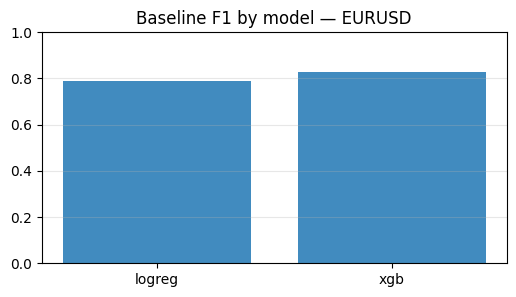

,acc,prec,rec,f1,auc
xgb,0.836,0.857,0.800,0.827,0.924
logreg,0.804,0.834,0.751,0.790,0.881


In [15]:

import matplotlib.pyplot as plt

plt.figure(figsize=(6,3))
plt.bar(list(results.keys()), [results[k]["f1"] for k in results], alpha=0.85)
plt.title(f"Baseline F1 by model — {ASSET_KEY.upper()}")
plt.ylim(0,1); plt.grid(axis="y", alpha=0.3); plt.show()

pd.DataFrame(results).T.sort_values("f1", ascending=False).round(3)


**Summary:**  
- **XGB** outperforms Logistic Regression across all metrics, with a notable lead in F1 and AUC.  
- Logistic Regression remains competitive but shows lower recall and overall predictive power.